In [ ]:
# Written by Prerna Singh, edited by John D'Uva

In [13]:
## Run model on 9L that was trained on 12L with random 10x NCR
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import sklearn.metrics

(12, 12, 12)

In [34]:
ROI1 = np.load('ROI_z2000:z2200_1.npy')
ROI2 = np.load('ROI_z2000:z2200_2.npy')
ROI4 = np.load('ROI_z2000:z2200_4.npy')
ROI1 = np.expand_dims(ROI1,0)
ROI2 = np.expand_dims(ROI2,0)
ROI4 = np.expand_dims(ROI4,0)
ROI_TEST = np.vstack((ROI1, ROI2, ROI4))
print("Total Number of Cell Regions: ", len(ROI_TEST))

NCR20 = np.load('NCR_z2000:z2200_20.npy')
NCR21 = np.load('NCR_z2000:z2200_21.npy')
NCR22 = np.load('NCR_z2000:z2200_22.npy')
NCR20 = np.expand_dims(NCR20,0)
NCR21 = np.expand_dims(NCR21,0)
NCR22 = np.expand_dims(NCR22,0)
NCR_TEST = np.vstack((NCR20, NCR21, NCR22))
print("Number of Non-Cell Regions:",len(NCR_TEST))

NCR_TEST = np.asarray(NCR_TEST)
print(NCR_TEST.shape)

ROI_TEST = np.asarray(ROI_TEST)
print(ROI_TEST.shape)

test = np.vstack((ROI_TEST, NCR_TEST))
#Test Data: 0-956 = cell
#Test Data: 956-10516 = non cell region
print("Number of Items in Test Data: %s" %len(test))
test = np.expand_dims(test, axis=1)
print('Shape of Test Data Vector:', test.shape)

Total Number of Cell Regions:  3
Number of Non-Cell Regions: 3
(3, 12, 12, 12)
(3, 12, 12, 12)
Number of Items in Test Data: 6
Shape of Test Data Vector: (6, 1, 12, 12, 12)


In [35]:
# m1 = torch.load('model2.pt')
# 1. Model Architecture
# INPUT: 
# - 1 x 12 x 12 x 12 image
# CONV1: 3d CONV
# MAXPOOL: 3d MP
# CONV2: 3d CONV
# CONV3: 3d CONV
# FC1: Fully Connected Layer
# FC2: Fully Connected Layer

class M1(nn.Module):
    def __init__(self):
        super(M1, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv3d(1,64, (5,5,5),padding = 2),nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.pool = nn.MaxPool3d((2, 2, 2),2) # kernel, stride
        self.conv2 = nn.Sequential(nn.Conv3d(64, 64, (3,3,3), padding = 1), nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.conv3 = nn.Sequential(nn.Conv3d(64, 64, (3,3,3), padding = 1), nn.Dropout(dr)) # in_channel, out_channel, kernel
        self.fc1 = nn.Sequential(nn.Linear(6*6*6*64,150),nn.Dropout(dr))
        self.fc2 = nn.Sequential(nn.Linear(150,1),nn.Dropout(dr))

    def forward(self,x):
#        print('Input Shape: ', x.shape)
        x = F.relu(self.conv1(x))
#        print('Shape after CONV1: ', x.shape)
        # Conv1 Activation: ReLU
        x = self.pool(x)
#         print('Shape after Maxpool: ', x.shape)
        # Followed by Maxpool
     
        x = F.relu(self.conv2(x))
#         print('Shape after CONV2: ', x.shape)
        # Conv2 Activation: ReLU
        
        x = F.relu(self.conv3(x))
#         print('Shape after CONV3: ', x.shape)
        # Conv3 Activation: ReLU
        
        x = x.reshape(x.size(0),-1)
#         print('Shape after flatten: ', x.shape)
        # flatten vector
              
        x = F.relu(self.fc1(x))
        # FC1 Activation: ReLU
#         print('Shape after FC1: ', x.shape)
        x = self.fc2(x)
        # FC2 Activation: None
#         print('Shape after FC2: ', x.shape)
        m = nn.Sigmoid()
#         print('Shape after Sigmoid Output: ', x.shape)

        x = m(x)
        # Output Activation: Sigmoid
        return x

#Hyperparamters
num_epochs = 200
batch_size = 5
learning_rate = 1e-3
momentum = 0.9
dr = 0.3
weight_decay = 1e-4
m1 = M1()

In [37]:
m1 = M1()
m1.load_state_dict(torch.load('model_trained_on12R_bias_corrected_goodtrain.pt', map_location = torch.device('cpu') ))
m1 = m1.double()

In [38]:
truelabels = []

for i in range(0,ROI_TEST.shape[0] ):
    truelabels.append(1)
for i in range(0,NCR_TEST.shape[0]):
    truelabels.append(0)

labels=[]
for i in range(0,len(test)):
    w = torch.from_numpy(test[i])
    w = w.unsqueeze(1)
    w = w.double()
    w = m1(w)
    labels.append(w.detach().numpy())

truelabels = np.asarray(truelabels)
labels = np.asarray(labels)
labels = labels.squeeze()

In [39]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(truelabels, labels)
mets = sklearn.metrics.precision_recall_curve(truelabels, labels, pos_label=None, sample_weight=None)
#np.save('positivecells.npy',positivecells)

In [40]:
auc = sklearn.metrics.roc_auc_score(truelabels, labels)
print('AUC: %.3f' % auc)

AUC: 0.222


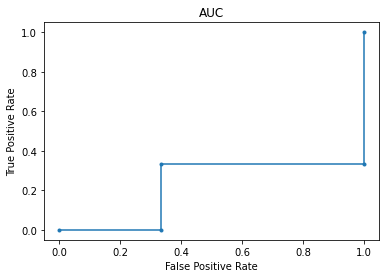

In [41]:
plt.plot(fpr, tpr, marker='.')
plt.title("AUC")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the plot
plt.show()

In [42]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(truelabels, labels)

# calculate F1 score
auc = sklearn.metrics.auc(recall, precision)

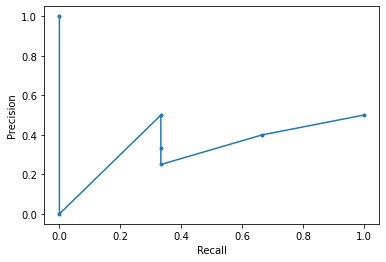

In [43]:
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()